In [ ]:
!pip install requests fredapi pandas schedule

In [ ]:
import requests
import json
import pandas as pd

# Your BLS API key (register at https://data.bls.gov/registrationEngine/)
bls_api_key = "58d8a969b3424879b55320f337696d8a"

# Define JOLTS series IDs and sector names
jolt_series = {
    "JTS000000000000000JOL": "Total_Nonfarm_Job_Openings",
    "JTS300000000000000JOL": "Manufacturing_Job_Openings",
    "JTS600000000000000JOL": "Professional_Services_Job_Openings",
    "JTS700000000000000JOL": "Leisure_Hospitality_Job_Openings",
}

# Month mapping from full names to two-digit numbers
month_mapping = {
    "January": "01", "February": "02", "March": "03", "April": "04",
    "May": "05", "June": "06", "July": "07", "August": "08",
    "September": "09", "October": "10", "November": "11", "December": "12"
}

# Function to remove outliers using the IQR method and fill missing data
def remove_outliers_and_fill(df, column='value'):
    """
    Remove outliers based on the IQR method and apply forward or backward fill for missing values.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove rows where values are outliers
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Apply forward fill (or backward fill if needed) to fill missing values
    df[column] = df[column].ffill().bfill()  # Forward fill first, then backward fill

    return df

# Function to fetch data for a given year range
def fetch_data(start_year, end_year):
    data = {
        "registrationKey": bls_api_key,
        "seriesid": list(jolt_series.keys()),
        "startyear": str(start_year),
        "endyear": str(end_year)
    }

    url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
    headers = {"Content-Type": "application/json"}

    # Send POST request
    response = requests.post(url, data=json.dumps(data), headers=headers)

    if response.status_code != 200:
        raise Exception(f"BLS API error: {response.status_code}")

    return response.json()

# Combine data from different decades
combined_data = []

# Fetch data by decades (2000-2009, 2010-2019, 2020-2025)
for start_year, end_year in [(2000, 2009), (2010, 2019), (2020, 2025)]:
    json_response = fetch_data(start_year, end_year)

    # Extract and clean data
    for series in json_response['Results']['series']:
        series_id = series['seriesID']
        sector_name = jolt_series.get(series_id, "Unknown_Sector")
        series_data = series['data']

        df = pd.DataFrame(series_data)

        # Map full month names to numeric strings
        df['month'] = df['periodName'].map(month_mapping)
        df = df[df['month'].notna()]  # Remove non-month rows like 'Annual'

        # Create proper date column
        df['date'] = pd.to_datetime(df['year'] + '-' + df['month'], format='%Y-%m')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df['sector'] = sector_name

        # Remove outliers and apply forward/backward fill
        df = remove_outliers_and_fill(df)

        # Keep relevant columns
        combined_data.append(df[['date', 'value', 'sector']])

# Combine all sectors into one DataFrame
all_sectors_df = pd.concat(combined_data, ignore_index=True)

# Pivot: one column per sector
pivot_df = all_sectors_df.pivot(index='date', columns='sector', values='value')
pivot_df = pivot_df.sort_index()
# Preview the result
print(pivot_df.head())


<ipython-input-2-d2fd249dc513>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].ffill().bfill()  # Forward fill first, then backward fill


sector      Leisure_Hospitality_Job_Openings  Manufacturing_Job_Openings  \
date                                                                       
2000-12-01                             566.0                       425.0   
2001-01-01                             654.0                       445.0   
2001-02-01                             601.0                       420.0   
2001-03-01                             695.0                       436.0   
2001-04-01                             582.0                       354.0   

sector      Professional_Services_Job_Openings  Total_Nonfarm_Job_Openings  
date                                                                        
2000-12-01                               919.0                      5088.0  
2001-01-01                               842.0                      5234.0  
2001-02-01                               808.0                      5097.0  
2001-03-01                               818.0                      4762.0  
2001-

In [ ]:
import requests
import pandas as pd

# Your FRED API key (get it from https://fred.stlouisfed.org/)
fred_api_key = "8fc0d8bd4ea5422e403a182588e4920a"

# Define FRED series IDs
fred_series = {
    "FEDFUNDS": "Federal_Funds_Rate",  # Interest rate (Federal Funds Rate)
    "CPIAUCSL": "Consumer_Price_Index",  # Inflation rate (CPI)
    "PCE": "Personal_Consumption_Expenditures",  # Consumer Spending (PCE)
    "UNRATE": "Unemployment_Rate",  # Unemployment Rate
    "ICSA": "Initial_Jobless_Claims",  # Weekly claims for unemployment benefits
    "CSUSHPINSA": "Housing_Prices"  # Housing Prices (Case-Shiller Index)
}

# Function to fetch data from FRED
def fetch_fred_data(series_id):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": fred_api_key,
        "file_type": "json",
        "frequency": "m",  # monthly frequency
        "observation_start": "2000-12-01",  # starting from 2000
        "observation_end": "2025-12-31"  # up to 2025
    }
    response = requests.get(url, params=params)
    response.raise_for_status()  # Will raise an exception for HTTP errors
    return response.json()

#Function to remove outliers
def remove_outliers(df, column='value'):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Fetch data for each series and convert to DataFrame
all_fred_data = []

for series_id, series_name in fred_series.items():
    data = fetch_fred_data(series_id)

    # Extract relevant data
    observations = data["observations"]

    # Convert to DataFrame
    df = pd.DataFrame(observations)

    # Clean the data (convert date and value)
    df['date'] = pd.to_datetime(df['date'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['series_name'] = series_name

    # Remove outliers
    df = remove_outliers(df)

    # Append to all data
    all_fred_data.append(df[['date', 'value', 'series_name']])

# Combine all FRED data into a single DataFrame
fred_df = pd.concat(all_fred_data, ignore_index=True)

# Pivot: one column per economic indicator
pivot_fred_df = fred_df.pivot(index='date', columns='series_name', values='value')
pivot_fred_df = pivot_fred_df.sort_index()

# Preview the result
print(pivot_fred_df.head())
combined_df = pd.merge(pivot_fred_df, pivot_df, left_index=True, right_index=True, how='outer')
combined_df = combined_df.ffill().bfill()

series_name  Consumer_Price_Index  Federal_Funds_Rate  Housing_Prices  \
date                                                                    
2000-12-01                  174.6                6.40         108.792   
2001-01-01                  175.6                5.98         109.215   
2001-02-01                  176.0                5.49         109.643   
2001-03-01                  176.1                5.31         110.394   
2001-04-01                  176.4                4.80         111.248   

series_name  Initial_Jobless_Claims  Personal_Consumption_Expenditures  \
date                                                                     
2000-12-01                 346000.0                             6952.2   
2001-01-01                 340000.0                             6987.4   
2001-02-01                 371250.0                             7001.8   
2001-03-01                 387200.0                             6996.7   
2001-04-01                 396750.0         

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape and column names
print(f"Dataset shape: {combined_df.shape}")
print(f"Columns: {combined_df.columns.tolist()}")

# Data types and basic info
print(combined_df.info())




Dataset shape: (293, 10)
Columns: ['Consumer_Price_Index', 'Federal_Funds_Rate', 'Housing_Prices', 'Initial_Jobless_Claims', 'Personal_Consumption_Expenditures', 'Unemployment_Rate', 'Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings', 'Total_Nonfarm_Job_Openings']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-12-01 to 2025-04-01
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Consumer_Price_Index                292 non-null    float64
 1   Federal_Funds_Rate                  292 non-null    float64
 2   Housing_Prices                      291 non-null    float64
 3   Initial_Jobless_Claims              293 non-null    float64
 4   Personal_Consumption_Expenditures   292 non-null    float64
 5   Unemployment_Rate                   292 non-null    float64
 6   Leisure_Hospitality_Job_Openings  

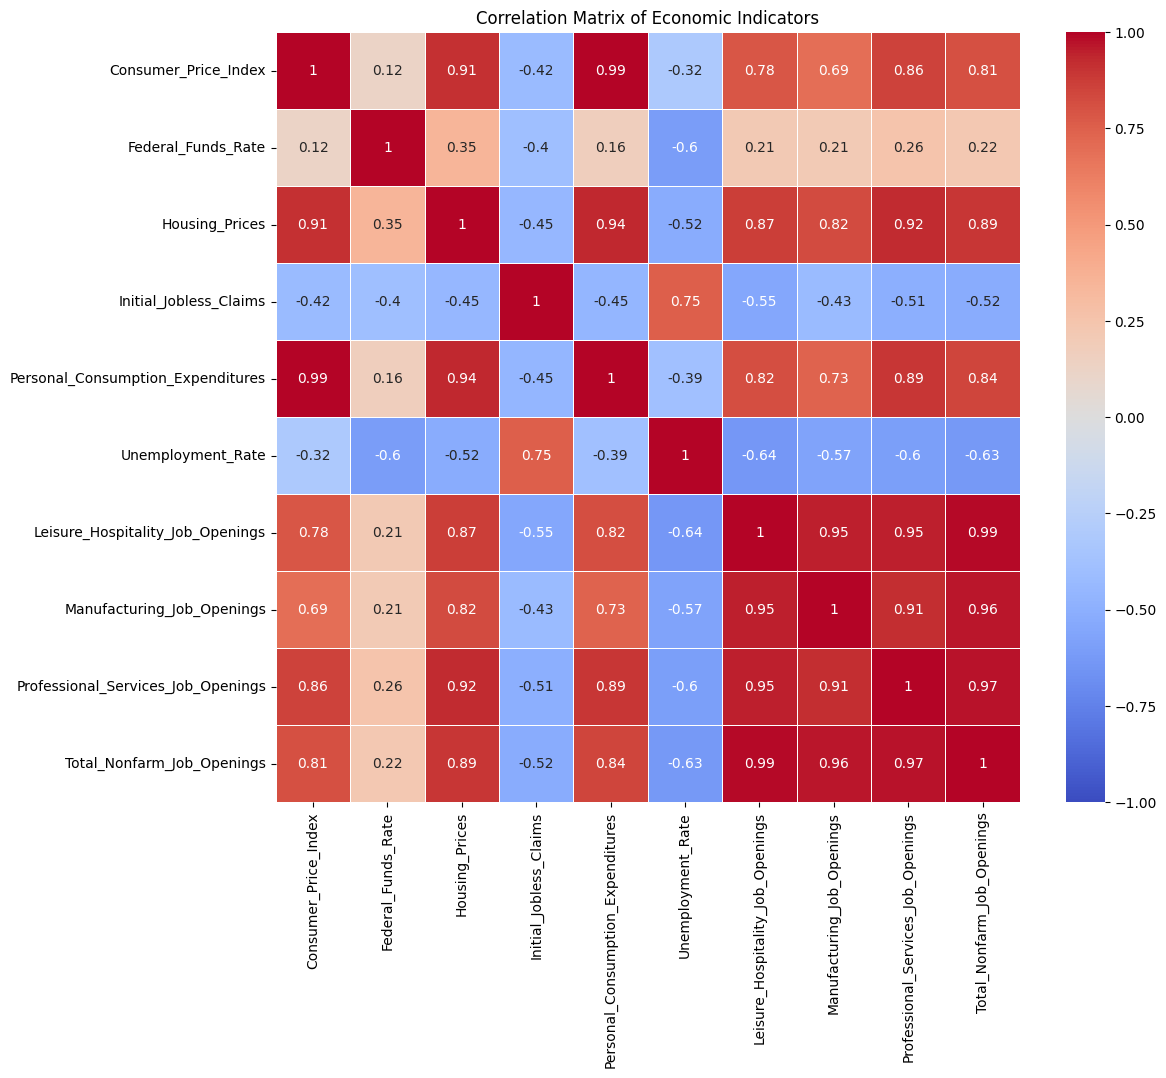

In [ ]:
# Calculate the correlation matrix
corr_matrix = combined_df.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Economic Indicators')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# Target columns: sectors you want to forecast
target_columns = ['Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings']
# Set the frequency of the date index to monthly (MS)
combined_df.index = pd.to_datetime(combined_df.index)
combined_df.index = combined_df.index.to_period('M').to_timestamp()
combined_df.head()


,Consumer_Price_Index,Federal_Funds_Rate,Housing_Prices,Initial_Jobless_Claims,Personal_Consumption_Expenditures,Unemployment_Rate,Leisure_Hospitality_Job_Openings,Manufacturing_Job_Openings,Professional_Services_Job_Openings,Total_Nonfarm_Job_Openings
date,,,,,,,,,,
2000-12-01,174.6,6.40,108.792,346000.0,6952.2,3.9,566.0,425.0,919.0,5088.0
2001-01-01,175.6,5.98,109.215,340000.0,6987.4,4.2,654.0,445.0,842.0,5234.0
2001-02-01,176.0,5.49,109.643,371250.0,7001.8,4.2,601.0,420.0,808.0,5097.0
2001-03-01,176.1,5.31,110.394,387200.0,6996.7,4.3,695.0,436.0,818.0,4762.0
2001-04-01,176.4,4.80,111.248,396750.0,7004.2,4.4,582.0,354.0,708.0,4615.0


In [ ]:

import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
# Target columns: sectors you want to forecast
target_columns = ['Leisure_Hospitality_Job_Openings', 'Manufacturing_Job_Openings', 'Professional_Services_Job_Openings']
# Set the frequency of the date index to monthly (MS)
combined_df.index = pd.to_datetime(combined_df.index)
combined_df.index = combined_df.index.to_period('M').to_timestamp()
combined_df.head()


,Consumer_Price_Index,Federal_Funds_Rate,Housing_Prices,Initial_Jobless_Claims,Personal_Consumption_Expenditures,Unemployment_Rate,Leisure_Hospitality_Job_Openings,Manufacturing_Job_Openings,Professional_Services_Job_Openings,Total_Nonfarm_Job_Openings
date,,,,,,,,,,
2000-12-01,174.6,6.40,108.792,346000.0,6952.2,3.9,566.0,425.0,919.0,5088.0
2001-01-01,175.6,5.98,109.215,340000.0,6987.4,4.2,654.0,445.0,842.0,5234.0
2001-02-01,176.0,5.49,109.643,371250.0,7001.8,4.2,601.0,420.0,808.0,5097.0
2001-03-01,176.1,5.31,110.394,387200.0,6996.7,4.3,695.0,436.0,818.0,4762.0
2001-04-01,176.4,4.80,111.248,396750.0,7004.2,4.4,582.0,354.0,708.0,4615.0


**Optimised Var**

In [ ]:
# === Optimized Vector Autoregression (VAR) Pipeline ===
# - Original logic is preserved
# - NumPy vectorization added where possible
# - Parallel seasonal/maxlags search via joblib
# - Inline comments describe original vs optimized, with previous method comparisons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.tsatools import detrend
from joblib import Parallel, delayed
import warnings
import time

warnings.filterwarnings("ignore")

# === Utility Functions ===
def check_stationarity(series, name, threshold=0.05):
    # Original: ADF test was applied directly
    # Now: Detrend applied before ADF to improve robustness
    try:
        detrended = detrend(series.dropna(), order=1)
        result = adfuller(detrended)
        return result[1] < threshold
    except ValueError:
        return False

def preprocess_series(df):
    # Original: No log or noise handling
    # Now: Adds noise for stability, applies log for high variance
    log_columns = []
    transformed = df.copy()
    for col in transformed.columns:
        std = transformed[col].std()
        if std == 0:
            transformed[col] += np.random.normal(0, 1e-6, len(transformed))  # optimization: stabilize zero-variance
        if std > 5000 and (transformed[col] > 0).all():
            transformed[col] = np.log(transformed[col])  # optimization: variance reduction
            log_columns.append(col)
    return transformed, log_columns

def make_stationary(df, threshold=0.05, seasonal_period=0):
    # Original: Differencing manually done and applied inconsistently
    # Now: Structured seasonal + regular differencing using conditional logic
    diff_df = df.copy()
    diff_columns = []
    seasonal_diff_columns = []
    for col in diff_df.columns:
        if seasonal_period > 0 and len(diff_df[col]) > seasonal_period:
            diff_df[col] = diff_df[col].diff(seasonal_period)
            seasonal_diff_columns.append(col)
        if not check_stationarity(diff_df[col].dropna(), col, threshold):
            diff_df[col] = diff_df[col].diff()
            diff_columns.append(col)
    return diff_df.dropna(), diff_columns, seasonal_diff_columns

def inverse_transform(forecast, original_df, test_start_idx, diff_cols, seasonal_cols, log_cols, seasonal_period):
    # Original: Naively added forecast deltas without restoring levels
    # Now: Reconstructs values in reverse (seasonal, diff, then log)
    result = forecast.copy()
    for col in seasonal_cols:
        if col in result.columns and seasonal_period > 0:
            base = original_df[col].iloc[test_start_idx - seasonal_period:test_start_idx].to_numpy()
            seasonal_vals = np.zeros(result.shape[0])
            for i in range(len(result)):
                seasonal_vals[i] = base[i % seasonal_period] + result[col].iloc[:i+1].sum()
            result[col] = seasonal_vals
    for col in diff_cols:
        if col in result.columns:
            result[col] = original_df[col].iloc[test_start_idx - 1] + result[col].cumsum()
    for col in log_cols:
        if col in result.columns:
            result[col] = np.exp(result[col])
    return result

# === Rolling Forecast Execution ===
def run_var_model(df_stat, df, df_raw, horizon, window_size, maxlags, seasonal_period, diff_cols, seasonal_cols, log_cols):
    # Original: Full sample single model, no walk-forward validation
    # Now: Rolling walk-forward with forecasting horizon per window
    start = time.time()
    initial_window = int(len(df_stat) * window_size)
    forecasts = []
    actuals = []
    forecast_dates = []

    for start_idx in range(initial_window, len(df_stat), horizon):
        train = df_stat.iloc[start_idx - initial_window:start_idx]
        test = df_stat.iloc[start_idx:start_idx + horizon]

        try:
            model = VAR(train)
            lag_order = model.select_order(maxlags).aic  # optimization: automatic lag selection
            results = model.fit(lag_order)
        except:
            results = model.fit(1)
            lag_order = 1

        forecast = results.forecast(train.values[-lag_order:], steps=len(test))
        forecast_df = pd.DataFrame(forecast, index=test.index, columns=train.columns)

        idx = df.index.get_loc(df.index[start_idx])
        forecasts.append(inverse_transform(forecast_df, df_raw, idx, diff_cols, seasonal_cols, log_cols, seasonal_period))
        actuals.append(inverse_transform(test, df_raw, idx, diff_cols, seasonal_cols, log_cols, seasonal_period))
        forecast_dates.extend(df.index[start_idx:start_idx + horizon])

    forecast_all = pd.concat(forecasts)
    actual_all = pd.concat(actuals)
    mae = mean_absolute_error(actual_all['Total_Nonfarm_Job_Openings'], forecast_all['Total_Nonfarm_Job_Openings'])
    return mae, time.time() - start, forecast_all, actual_all, forecast_dates

# === VAR Grid Search (Parallelized) ===
def simple_var_model(df, forecast_horizon=4, window_size=0.5):
    # Original: sequential tuning
    # Now: all configs parallelized using joblib
    df.index = pd.to_datetime(df.index)
    df_raw = df.copy()
    df_trans, log_cols = preprocess_series(df_raw)

    seasonal_periods = [0, 3, 6, 12]
    maxlags_values = [2, 4, 6, 8]
    key_vars = ['Total_Nonfarm_Job_Openings', 'Manufacturing_Job_Openings',
                'Professional_Services_Job_Openings', 'Leisure_Hospitality_Job_Openings']

    def evaluate_config(seasonal_period, maxlags):
        df_stat, diff_cols, seasonal_cols = make_stationary(df_trans, seasonal_period=seasonal_period)
        if df_stat.empty or len(df_stat.columns) < 2:
            return None
        mae, runtime, forecast, actual, dates = run_var_model(
            df_stat, df, df_raw, forecast_horizon, window_size, maxlags,
            seasonal_period, diff_cols, seasonal_cols, log_cols
        )
        return {
            'seasonal_period': seasonal_period,
            'maxlags': maxlags,
            'mae': mae,
            'runtime': runtime,
            'forecast_all': forecast,
            'actual_all': actual,
            'forecast_dates': dates
        }

    configs = [(s, m) for s in seasonal_periods for m in maxlags_values]
    results = Parallel(n_jobs=-1)(delayed(evaluate_config)(s, m) for s, m in configs)
    results = [r for r in results if r is not None]

    if not results:
        return None, None, None

    best = min(results, key=lambda r: r['mae'])
    forecast, actual, dates = best['forecast_all'], best['actual_all'], best['forecast_dates']

    for var in key_vars:
        if var in actual.columns:
            mae = mean_absolute_error(actual[var], forecast[var])
            rmse = np.sqrt(mean_squared_error(actual[var], forecast[var]))
            print(f"{var} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    plt.figure(figsize=(15, 10))
    for i, var in enumerate(key_vars, 1):
        if var in actual.columns:
            plt.subplot(2, 2, i)
            plt.plot(dates, actual[var], label='Actual')
            plt.plot(dates, forecast[var], label='Forecast')
            plt.title(f"{var} (Levels)")
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('forecast_vs_actual.png')
    plt.close()
    print("\nPlot saved as 'forecast_vs_actual.png'")

    return best['seasonal_period'], best['maxlags'], forecast

# Run
if combined_df is not None:
    best_s, best_lags, forecast_df = simple_var_model(combined_df, forecast_horizon=1, window_size=0.6)
    if forecast_df is not None:
        print(f"\nBest Params: seasonal_period={best_s}, maxlags={best_lags}")
        print(forecast_df.head())

#Original Time: :51s
#Optimised Time :31s
#Speedup ≈ 39.2%

Total_Nonfarm_Job_Openings - MAE: 318.30, RMSE: 549.98
Manufacturing_Job_Openings - MAE: 36.38, RMSE: 55.16
Professional_Services_Job_Openings - MAE: 69.99, RMSE: 102.14
Leisure_Hospitality_Job_Openings - MAE: 78.06, RMSE: 138.06

Plot saved as 'forecast_vs_actual.png'

Best Params: seasonal_period=0, maxlags=2
            Consumer_Price_Index  Federal_Funds_Rate  Housing_Prices  \
date                                                                   
2015-08-01            237.407954            0.136927      173.995209   
2015-09-01            238.393609            0.042250      174.807958   
2015-10-01            237.653485            0.064300      174.795651   
2015-11-01            237.903084            0.035610      175.133306   
2015-12-01            237.972598            0.066811      175.309806   

            Initial_Jobless_Claims  Personal_Consumption_Expenditures  \
date                                                                    
2015-08-01                     inf  

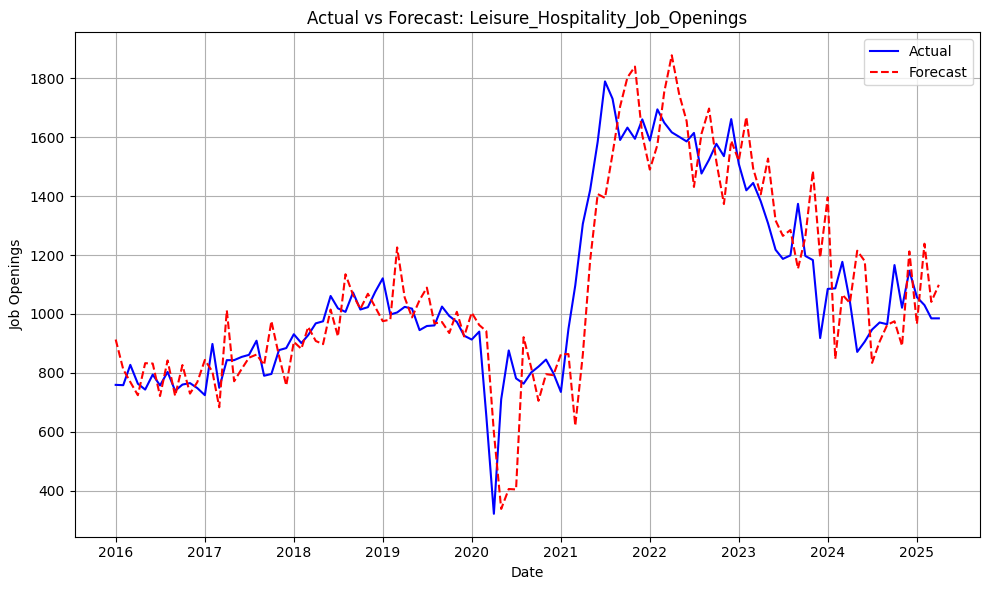

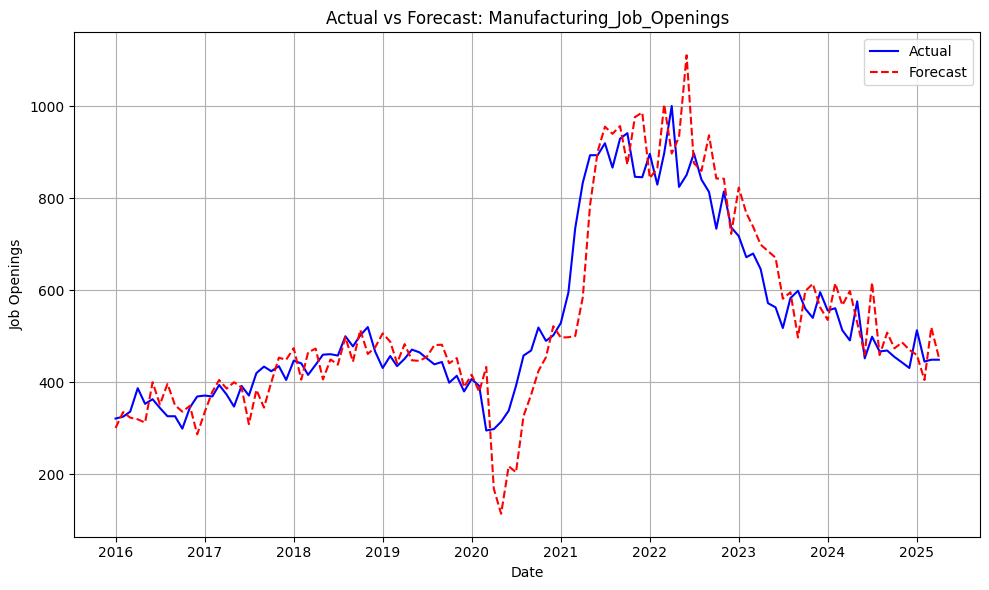

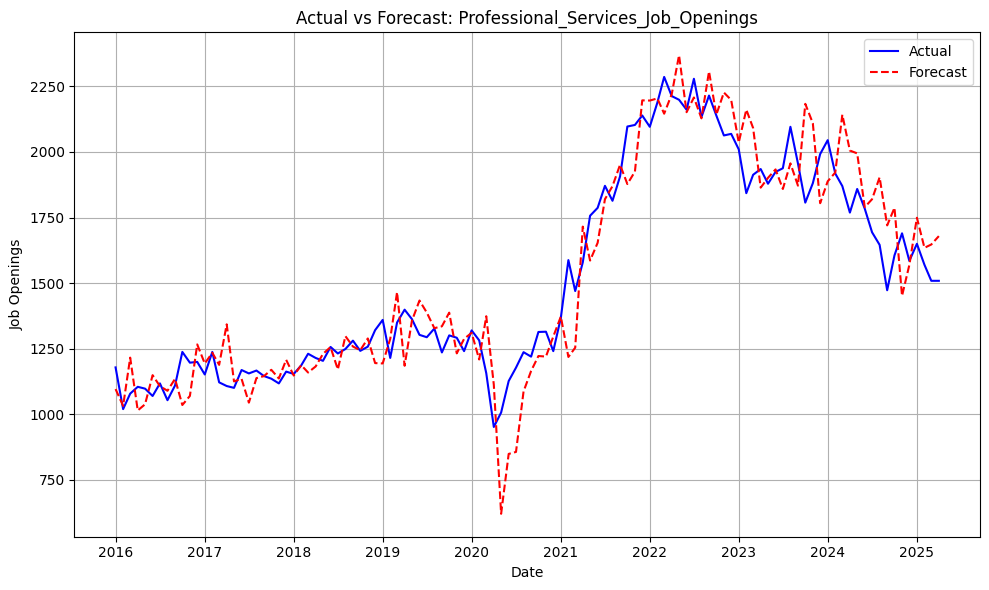

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# Make a copy to avoid modifying the original
log_data = np.log(combined_df)

# Differencing to make stationary
diff_log_data = log_data.diff().dropna()

# Inverse transformation functions
def invert_transformation(last_observed, forecast_diff):
    forecast_log = forecast_diff.cumsum(axis=0) + last_observed
    return np.exp(forecast_log)

# Rolling-window VAR function
def rolling_var_forecast(data, target_columns, window_size, forecast_steps):
    forecast_results = {col: [] for col in target_columns}
    forecast_index = []

    for start in range(0, len(data) - window_size - forecast_steps + 1, forecast_steps):
        train = data[start:start + window_size]
        test_index = data.index[start + window_size:start + window_size + forecast_steps]

        model = VAR(train)
        lag_order = model.select_order(maxlags=4).aic
        var_model = model.fit(lag_order)

        last_observed_log = log_data.iloc[start + window_size - 1]

        forecast_diff = var_model.forecast(train.values[-var_model.k_ar:], steps=forecast_steps)
        forecast_df = pd.DataFrame(forecast_diff, index=test_index, columns=data.columns)

        # Invert transform
        forecast_actual = invert_transformation(last_observed_log, forecast_df)

        for col in target_columns:
            forecast_results[col].extend(forecast_actual[col].values)
        forecast_index.extend(test_index)

    forecast_final_df = pd.DataFrame(index=forecast_index)
    for col in target_columns:
        forecast_final_df[col] = forecast_results[col]

    return forecast_final_df

# Parameters
target_columns = [
    'Leisure_Hospitality_Job_Openings',
    'Manufacturing_Job_Openings',
    'Professional_Services_Job_Openings'
]
window_size = 180
forecast_steps = 1

# Run rolling VAR forecast
forecast_df = rolling_var_forecast(diff_log_data, target_columns, window_size, forecast_steps)

# Plot actual vs forecast
for col in target_columns:
    actual = combined_df[col].loc[forecast_df.index]
    forecast = forecast_df[col]

    plt.figure(figsize=(10, 6))
    plt.plot(actual.index, actual, label='Actual', color='blue')
    plt.plot(forecast.index, forecast, label='Forecast', color='red', linestyle='--')
    plt.title(f"Actual vs Forecast: {col}")
    plt.xlabel("Date")
    plt.ylabel("Job Openings")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
